In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy import symbols, diff

import warnings 
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'
sns.set(style='ticks')

plt.rc('figure', figsize=(6, 3.7), dpi=100) 
plt.rc('axes', labelpad=20, facecolor="#ffffff",
       linewidth=0.4, grid=True, labelsize=10) 
plt.rc('xtick.major', width=0.2) 
plt.rc('ytick.major', width=0.2) 
plt.rc('grid', color='#EEEEEE', linewidth=0.25)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('savefig', pad_inches=0.3, dpi=300)

# Input Parameters

In [2]:
Tubing_Dia_m=62.3E-03  ## in m
Roughness=30.0E-06  ## in m
Area_Cross_Section=(math.pi*Tubing_Dia_m**2)/4   ## in m2 
Water_Cut=0.2
GOR=50  ## in m3/m3
Std_Oil_Density=850  ## in kg/m3
Water_Density=1050  ## in kg/m3
Sp_gr_oil= Std_Oil_Density/1000
API_gr=(141.5/Sp_gr_oil)-131.5
Depth_Total=3000  ## in m
Depth= Depth_Total ## in m
Pwf=30525770  ## in Pa
Bw=1
Qosci=0.005  ## in m3/s
Gas_Oil_IFT=0.008  ## in N/m
Gas_Water_IFT=0.04  ## in N/m
Gas_Density_Standard=0.95  ## in kg/m3
Gas_Gravity=0.77
Water_Viscosity_Pas=0.35E-03  ## in Pas
FBHT=120  ## in deg C
FTHT=30  ## in deg C
Temp_Gradient= (FBHT-FTHT)/Depth_Total
Well_Inclination=math.pi/2
Dimensionless_Roughness= Roughness/Tubing_Dia_m
Molecular_Weight=28.97*Gas_Gravity
P_sc=1E05  ## in Pa
T=FTHT

# Calculations

In [3]:
## Newton Raphson
def newton_raphson(f, x_symbolic, x0, max_iter, tol=1e-06 ):
    x = x0
    f_prime = diff(f, x_symbolic)
    
    for i in range(max_iter):
        f_prime_val  = f_prime.subs(x_symbolic, x)
        x_new = x- f.subs(x_symbolic, x)/f_prime_val
        
        if abs(x_new - x)< tol:
            return x_new
        
        x = x_new
        
    raise ValueError('cannot converge')

In [4]:
def func(A, P, x, t):
        return (-A*P/6894.76)+((x+x**2+x**3-x**4)/(1-x)**3)-((14.76*t-9.76*t**2+4.58*t**3)*x**2)+(90.7*t-242*t**2+42.4*t**3)*x**(2.18+2.82*t)

def func_derivative(A, P, x, t):
    return -2*x*(4.58*t**3 - 9.76*t**2 + 14.76*t) + (-4*x**3 + 3*x**2 + 2*x + 1)/(1 - x)**3 + 3*(-x**4 + x**3 + x**2 + x)/(1 - x)**4 + x**(2.82*t + 1.18)*(2.82*t + 2.18)*(42.4*t**3 - 242*t**2 + 90.7*t)

def newton_raphson(initial_guess, tol=1e-6, max_iter=1000):
    x = initial_guess
    for i in range(max_iter):
        fx=func(A, P, x, t)
        f_prime_x=func_derivative(A, P, x, t)

        x = x - fx / f_prime_x

        if abs(fx) < tol:
            return x   
    return x

## Newton Raphson
def newton_raphson(f, x0, max_iter, tol=1e-05):
    try:
        return newton(f, x0, tol=tol, maxiter=max_iter)
    except RuntimeError:
        raise ValueError('Cannot converge')

In [5]:

qsteps=np.linspace(Qosci,0,15)
Pwh_Data= []
P_Head_Data=[]
P_Fric_Data=[]
P_Acc_Data=[]
Qosc_Data = []
Mixture_Density_Data=[]
Liquid_Holdup_Data=[]
Gas_Holdup_Data=[]
Liquid_Velocity_Data=[]
Gas_Velocity_Data=[]
Mixture_Velocity_Data=[]


for Qosc in qsteps:
    Delta_Depth=-10
    Depth_m= 10
    Sum_Delta_Depth=0
    P=Pwf
    P_Head_Loss=Pwf
    P_Fric_Loss=Pwf
    P_Acc_Loss=Pwf
    Qwsc=Water_Cut*Qosc/(1-Water_Cut)  ## in m3/s
    Qgsc= GOR*Qosc  ## in m3/s
    while Depth_m >=0 and Sum_Delta_Depth>=(-3000):
        Depth_m=Depth+Sum_Delta_Depth
        T=Temp_Gradient*Depth_m+FTHT
        T_F=(T*9/5)+32  ## deg Fah
        T_Ran=(T*9/5)+491.67  ## deg R
        T_abs= T+273.15  ## in deg K
        
        ## Computation of Z
        
        P_pc_psi=756.8-131.07*Gas_Gravity-3.6*Gas_Gravity**2
        P_pc_Pa= P_pc_psi*6894.76
        T_pc_Ran= 169.2+349.5*Gas_Gravity-74*Gas_Gravity**2
        T_pc_K=T_pc_Ran*5/9
        t=T_pc_Ran/T_Ran
       
        A=0.06125*t*math.exp(-1.2*(1-t)**2)/P_pc_psi
        def func(A, P, x, t):
            calc = (-A*P/6894.76)+((x+x**2+x**3-x**4)/(1-x)**3)-((14.76*t-9.76*t**2+4.58*t**3)*x**2)+(90.7*t-242*t**2+42.4*t**3)*x**(2.18+2.82*t)
            return calc

        def func_derivative(A, P, x, t):
            return -2*x*(4.58*t**3 - 9.76*t**2 + 14.76*t) + (-4*x**3 + 3*x**2 + 2*x + 1)/(1 - x)**3 + 3*(-x**4 + x**3 + x**2 + x)/(1 - x)**4 + x**(2.82*t + 1.18)*(2.82*t + 2.18)*(42.4*t**3 - 242*t**2 + 90.7*t)

        def newton_raphson_x(initial_guess=0.1, tol=1e-5, max_iter=1000):
            x = initial_guess
            for i in range(max_iter):
                fx=func(A, P, x, t)
                f_prime_x=func_derivative(A, P, x, t)

                fx_real = float(fx.real)
                f_prime_x_real = float(f_prime_x.real)
                
                x_temp = float(x - fx_real / f_prime_x_real)
                x = x_temp

                if abs(fx_real) < tol:
                    return x   
            return x

      
        g = newton_raphson_x()
        Z = A*P/(g*6894.76)
        
        
        ## Computation of Oil Viscosity, Bo, Rs, and Oil Density
        
        d=0.0125*API_gr-0.00091*(T_Ran-460)        
        Rs= Gas_Gravity*((P/(6894.76*18.2)+1.4)*(10**d))**1.2048  ## in scf/STB  (Standing Correlation)
        Rs_SI=Rs*0.178  ## Sm3/Sm3
        
        Bo=0.9759+0.00012*((Rs*(Gas_Gravity/Sp_gr_oil)**0.5)+(1.25*(T_Ran-460)))**1.2  ## in bbl/scf (Standing Correlation)
        Bo_SI= Bo*5.615  ## in m3/m3
        
        a=3.0324-0.02023*API_gr
        b=10**a
        c=b*T_F**(-1.163)
        Dead_Oil_Viscosity=10**c-1
        F=10.715*(Rs+100)**(-0.515)
        B=5.44*(Rs+150)**(-0.338)
        Oil_Viscosity= F*Dead_Oil_Viscosity**B  ## in cp
        Oil_Viscosity_Pas= Oil_Viscosity*0.001  ## in Pas
        Oil_Density_SI=(Std_Oil_Density+Rs*Gas_Density_Standard)/Bo  ## kg/m3

        
        ## Computation of local fluid properties
        qo=Bo*Qosc
        qw=Bw*Qwsc
        ql=qo+qw
        
        Viscosity_Liquid=((1-Water_Cut)*Oil_Viscosity_Pas)+(Water_Cut*Water_Viscosity_Pas)  ## in Pas
        Liquid_Density_SI=((1-Water_Cut)*Oil_Density_SI)+(Water_Cut*Water_Density)
        Gas_Liquid_IFT=((1-Water_Cut)*Gas_Oil_IFT)+(Water_Cut*Gas_Water_IFT)
        
        
        ## Computation of dz/dp
        h= 1e-5
        P_h=P-h
        def func1(A, P_h, y, t):
            return (-A*P/6894.76)+((y+y**2+y**3-y**4)/(1-y)**3)-((14.76*t-9.76*t**2+4.58*t**3)*y**2)+(90.7*t-242*t**2+42.4*t**3)*y**(2.18+2.82*t)

        def func1_derivative(A, P_h, y, t):
            return -2*y*(4.58*t**3 - 9.76*t**2 + 14.76*t) + (-4*y**3 + 3*y**2 + 2*y + 1)/(1 - y)**3 + 3*(-y**4 + y**3 + y**2 + y)/(1 - y)**4 + y**(2.82*t + 1.18)*(2.82*t + 2.18)*(42.4*t**3 - 242*t**2 + 90.7*t)

        def newton_raphson_y(initial_guess=0.1, tol=1e-5, max_iter=1000):
            y = initial_guess
            for i in range(max_iter):
                f1y=func1(A, P_h, y, t)
                f1_prime_y=func1_derivative(A, P_h, y, t)

                f1y_real = float(f1y.real)
                f1_prime_y_real = float(f1_prime_y.real)

                y_temp = float(y - f1y_real / f1_prime_y_real)
                y = y_temp

                if abs(f1y_real) < tol:
                    return y   
            return y

      
        y = newton_raphson_y()
        Z_h = A*P_h/(y*6894.76)
        dzdp=(Z_h-Z)/(P_h-P)
        
        ## Computation of Gas Density & Viscosity
        
        Gas_Density= 0.00149406*P*Molecular_Weight/(Z*T_Ran*6894.76)
        Gas_Density_SI=Gas_Density*1000 ## in kg/m3
        
        K1=(0.00094+0.000002*Molecular_Weight)*(T_Ran**1.5)/(200+19*Molecular_Weight+T_Ran)
        X=3.5+(986/T_Ran)+(0.01*Molecular_Weight)
        Y=2.4-0.2*X
        Gas_Viscosity=K1*math.exp(X*Gas_Density**Y)
        Gas_Viscosity_Pas=Gas_Viscosity*0.001
        
        Bg=Gas_Density_Standard/Gas_Density_SI
        qg= Bg*Qgsc
        

        ##Computation of Superficial and mixture velocities in m/s
        Velocity_oil=qo/Area_Cross_Section
        Velocity_liquid=ql/Area_Cross_Section
        Velocity_gas=qg/Area_Cross_Section
        Velocity_mixture=Velocity_liquid+Velocity_gas

        
        ## Computation of dimensionless group
        N_lv=Velocity_liquid*(Liquid_Density_SI/(9.81*Gas_Liquid_IFT))**0.25
        N_gv=Velocity_gas*(Liquid_Density_SI/(9.81*Gas_Liquid_IFT))**0.25
        N_d=Tubing_Dia_m*(9.81*Liquid_Density_SI/Gas_Liquid_IFT)**0.5
        N_mu=Viscosity_Liquid*(9.81/(Liquid_Density_SI*Gas_Liquid_IFT**3))**0.25
        
        ## Computation of corrected liquid viscosity number
        x1=N_mu
        a0 =  1.9122E-03
        a1 =  5.6348E-02
        a2 = -1.2183E-01
        a3 =  9.0950E-02
        if x1<0.002 or x1>0.5:
            print('Parameter x1 out of bounds. Hagedorn and Brown correlation not valid.')
            break
        else:
            y1=a3*x1**3 + a2*x1**2 + a1*x1 + a0
            N_mu_c=y1
            
        ## Computation of x2 and y2
        b0 =  1.8089E-05
        b1 = -9.9787E-04
        b2 =  1.0029E-02
        b3 =  3.6917E-01
        c0 =  1.9585E-05
        c1 = -1.2769E-03
        c2 =  2.7058E-02
        c3 = -4.8940E-02
        c4 =  1.0000E+00
        x2 = N_gv*(N_mu**0.380)/(N_d**2.14)
        if x2 < 0 or x2 > 0.088:
            print('Parameter x2 out of bounds. Hagedorn and Brown correlation not valid.')
            break
        elif x2>0.01:
            y2=(b3*x2**3 + b2*x2**2 + b1*x2 + b0)/ (c4*x2**4 + c3*x2**3 + c2*x2**2 + c1*x2 + c0)
        else:
            y2=1
        
        si=y2 ## correction factor
        
        ## Computation of x3 & y3
        d0 =  4.3260E-11
        d1 = -3.7902E-05
        e0 = -3.7520E-10
        e1 = -1.9323E-04
        e2 =  1.0000E+00
        f0 =  6.4898E-05
        f1 =  1.1470E+00
        f2 = -1.8530E+01
        g0 = 4.5319E-04
        g1 = 1.0000E+00
        x3=(N_lv/(N_gv**0.575))*(P/P_sc)**0.10*(N_mu_c/N_d)
        if x3 < 0.0000021:
            print('Parameter x3 out of bounds. Hagedorn and Brown correlation not valid.')
            break
        elif x3>=0.0000021 and x3<=4.64229E-05:
            y3=(d1*x3+d0)/(e2*x3**2+e1*x3+e0)
        elif x3>4.64229E-05 and x3<=5E-03:
            y3=(f2*x3**2+f1*x3+f0)/(g1*x3+g0)
        else:
            y3=0.98
        
        H_l=si*y3  ## Liquid Holdup
        
        ## Compute liquid and gas volume fractions (no-slip)
        lambda_l= ql/(ql+qg)  ## Liquid Vol Fraction
        lambda_g=1-lambda_l  ## Gas Vol Fraction
        
        ## Perform reality check
        if H_l< lambda_l:
            H_l=lambda_l
            
        H_g=1-H_l  ## Gas holdup
        
        ## Computation of mixture properties
        
        Viscosity_Mixture= Viscosity_Liquid**H_l*Gas_Viscosity_Pas**H_g

        Density_Mixture=H_g*Gas_Density_SI+H_l*Liquid_Density_SI
        
        ## Computation of Nr & Friction Factor
        Nre= Density_Mixture*Velocity_mixture*Tubing_Dia_m/Viscosity_Mixture
        
        if Qosc == 0:
            ff=0
        else:
            ff=0.25/(math.log10((Dimensionless_Roughness/3.7)+(5.74/Nre**0.9)))**2
        
        ## Computation of Pressure gradients & Pressure
        
        Dimensionless_Mixture_KE=Density_Mixture*Velocity_gas*Velocity_mixture/P
        dpds_grav=Density_Mixture*9.8*math.sin(Well_Inclination)
        Head_Loss=dpds_grav*Delta_Depth
        P_Head_Loss=P_Head_Loss+Head_Loss
        
        dpds_fric=(Density_Mixture*Velocity_mixture**2*ff/2/Tubing_Dia_m)
        Friction_Loss=dpds_fric*Delta_Depth
        P_Fric_Loss=P_Fric_Loss+Friction_Loss
        
        dpds_acc=(dpds_grav+dpds_fric)*Dimensionless_Mixture_KE/(1-Dimensionless_Mixture_KE)
        Acceleration_Loss=dpds_acc*Delta_Depth
        P_Acc_Loss=P_Acc_Loss+Acceleration_Loss
        
        Total_Loss= Head_Loss+Friction_Loss+Acceleration_Loss            
            
        Sum_Delta_Depth=Sum_Delta_Depth+Delta_Depth
        P=P+Total_Loss
        
    
    Pwh_Data.append(P)
    P_Head_Data.append(P_Head_Loss)
    P_Fric_Data.append(P_Fric_Loss)
    P_Acc_Data.append(P_Acc_Loss)
    Qosc_Data.append(Qosc)
    Mixture_Density_Data.append(Density_Mixture)
    Mixture_Velocity_Data.append(Velocity_mixture)
    Liquid_Holdup_Data.append(H_l)
    Gas_Holdup_Data.append(H_g)
    Liquid_Velocity_Data.append(Velocity_liquid)
    Gas_Velocity_Data.append(Velocity_gas)

# Plotting

In [6]:
Pwh_df=pd.DataFrame(Pwh_Data, columns=['Pwh-Pa'])
Qo_df=pd.DataFrame(Qosc_Data, columns=['Qosc-m3/sec'])
Mix_density_df=pd.DataFrame(Mixture_Density_Data, columns=['Mixture Density-kg/m3'])
Mix_Velocity_df=pd.DataFrame(Mixture_Velocity_Data, columns=['Mixture Velocity-m/sec'])
Liq_Holdup_df=pd.DataFrame(Liquid_Holdup_Data, columns=['H_l'])
Gas_Holdup_df=pd.DataFrame(Gas_Holdup_Data, columns=['H_g'])
Liq_Velocity_df=pd.DataFrame(Liquid_Velocity_Data, columns=['Liquid Velocity-m/sec'])
Gas_Velocity_df=pd.DataFrame(Gas_Velocity_Data, columns=['Gas Velocity-m/sec'])
result_df = pd.concat([Qo_df, Pwh_df, Mix_density_df, Mix_Velocity_df, Liq_Holdup_df, Gas_Holdup_df, Liq_Velocity_df, Gas_Velocity_df], axis=1)
result_df.to_excel('final_result_TPR.xlsx', index=False)

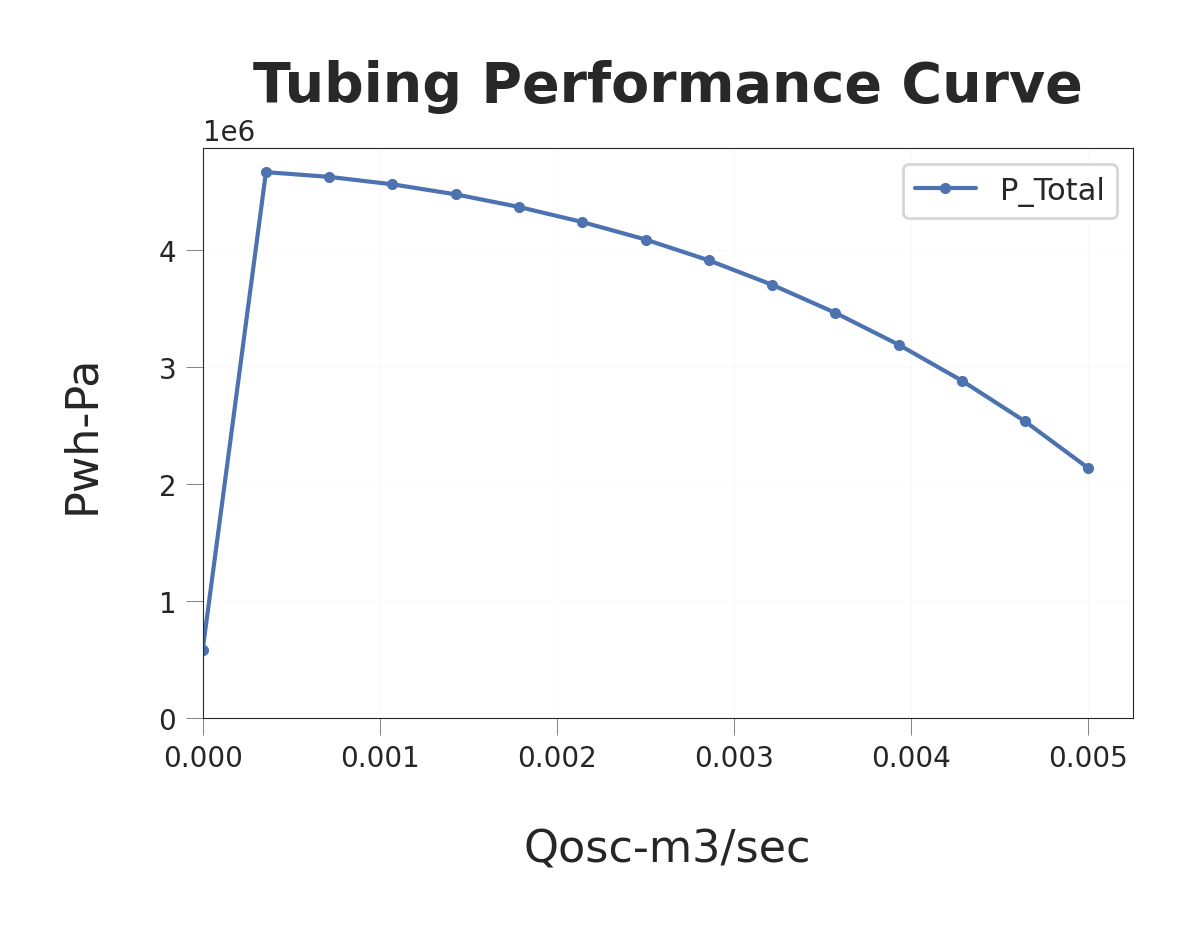

In [7]:
plt.plot(Qosc_Data, Pwh_Data, marker='.', label='P_Total')
##plt.plot(Qosc_Data, P_Head_Data, marker='.', label='P_Head')
##plt.plot(Qosc_Data, P_Fric_Data, marker='.', label='P_Fric')
##plt.plot(Qosc_Data, P_Acc_Data, marker='.', label='P_Acc')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True, alpha=0.5)
plt.xlabel('Qosc-m3/sec', fontsize=16)
plt.ylabel('Pwh-Pa', fontsize=16)
plt.title('Tubing Performance Curve', fontsize=20, fontweight='bold')
plt.legend()
plt.show()